In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('gans-anime-faces')
jovian.set_colab_id('1bcDQBG_wEvkyp8eUNMqDRoHTvAAZ-fsU')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
project_name= 'gans-anime-faces'

In [ ]:
# Downloading the dataset from the kaggle (anime faces dataset)
import opendatasets as od

dataset_url= 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lakshaygola
Your Kaggle Key: ··········


  7%|▋         | 27.0M/395M [00:00<00:01, 282MB/s]

100%|██████████| 395M/395M [00:01<00:00, 238MB/s]


In [ ]:
# Saving the working dir
import os

data_dir= './animefacedataset'
print(os.listdir(data_dir))

['images']


In [ ]:
print(os.listdir(data_dir+'/images')[:20])

['1088_2001.jpg', '61992_2019.jpg', '17072_2007.jpg', '20044_2007.jpg', '49875_2015.jpg', '47873_2014.jpg', '60299_2018.jpg', '21976_2008.jpg', '30371_2010.jpg', '10008_2004.jpg', '3288_2002.jpg', '46201_2014.jpg', '53365_2016.jpg', '44056_2013.jpg', '27661_2009.jpg', '31463_2010.jpg', '19704_2007.jpg', '10604_2005.jpg', '61831_2018.jpg', '20220_2007.jpg']


In [ ]:
from torchvision import transforms as tt
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [ ]:
stats= (0.5,0.5,0.5), (0.5,0.5,0.5)
batch_size= 130
image_size= 64

In [ ]:
train_data= ImageFolder(data_dir, transform= tt.Compose([tt.Resize(image_size), tt.CenterCrop(image_size), tt.ToTensor(), tt.Normalize(*stats)]))

In [ ]:
train_loader= DataLoader(train_data, batch_size, shuffle= True, pin_memory=True, num_workers=3)

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to Denormalize the images
def denorm(image):
  return image * stats[1][0] + stats[0][1]

# Function to make the grid of the batch image
def show_grid(image, num_image= 70):
    fig,ax= plt.subplots(figsize= (15,15))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(denorm(image.detach()[:num_image]), nrow= 10).permute(1,2,0))

def show_batch(batch, num_images= 60):
  for image, _ in batch:
     show_grid(image, num_images)
     break

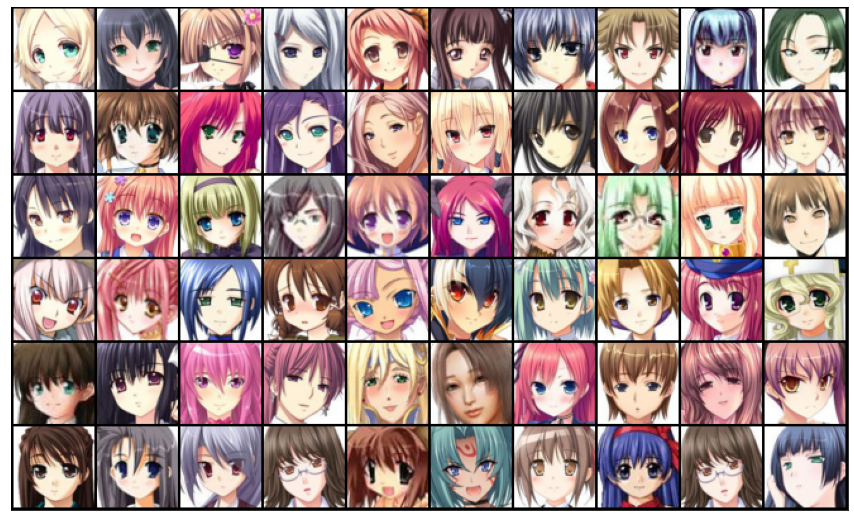

In [ ]:
# Let see the image from the dataset
show_batch(train_loader)

# Using GPUs

In [ ]:
import torch

In [ ]:
def get_device():
  if torch.cuda.is_available:
    return ('cuda')
  else:
    return ('cpu')

def to_device(data, device):
  if isinstance(data, (tuple, list)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking= True)

class DeviceDataLoader():
  def __init__(self, batch,device):
    self.dl= batch
    self.device= device

  def __iter__(self):
    for b in self.dl:
      yield to_device (b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
torch.cuda.empty_cache()

# Discriminator Network
used to predict wheather images is belong to dataset or generated by the image

In [ ]:
import torch.nn as nn

In [ ]:
# Creating the discriminator variable
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size= 4, padding= 1, stride= 2, bias= False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace= True),

    nn.Conv2d(64,128, kernel_size=4, stride= 2, padding= 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace= True),

    nn.Conv2d(128,256, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace= True),

    nn.Conv2d(256,512, kernel_size= 4, stride= 2, padding= 1, bias= False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace= True),

    nn.Conv2d(512, 1, kernel_size= 4, stride= 1, padding= 0, bias= False),

    nn.Flatten(),
    nn.Sigmoid()
)

# Generator network
used to genertor the image from random input tensor

In [ ]:
latent_size= 128

In [ ]:
# Creating the Generator network
generator= nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size= 4, padding=0, stride= 1, bias= False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace= True),

    nn.ConvTranspose2d(512, 256, kernel_size= 4, padding=1, stride= 2, bias= False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace= True),

    nn.ConvTranspose2d(256, 156, kernel_size= 4, padding=1, stride= 2, bias= False),
    nn.BatchNorm2d(156),
    nn.ReLU(inplace= True),

    nn.ConvTranspose2d(156, 64,kernel_size= 4, padding=1, stride= 2, bias= False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace= True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, padding= 1, stride= 2, bias= False),
    nn.Tanh()
)

In [ ]:
# Getting the avialabel device for the workspace
device= get_device()
device

'cuda'

In [ ]:
# moving the dataloader on device
train_loader= DeviceDataLoader(train_loader, device)

torch.Size([130, 3, 64, 64])


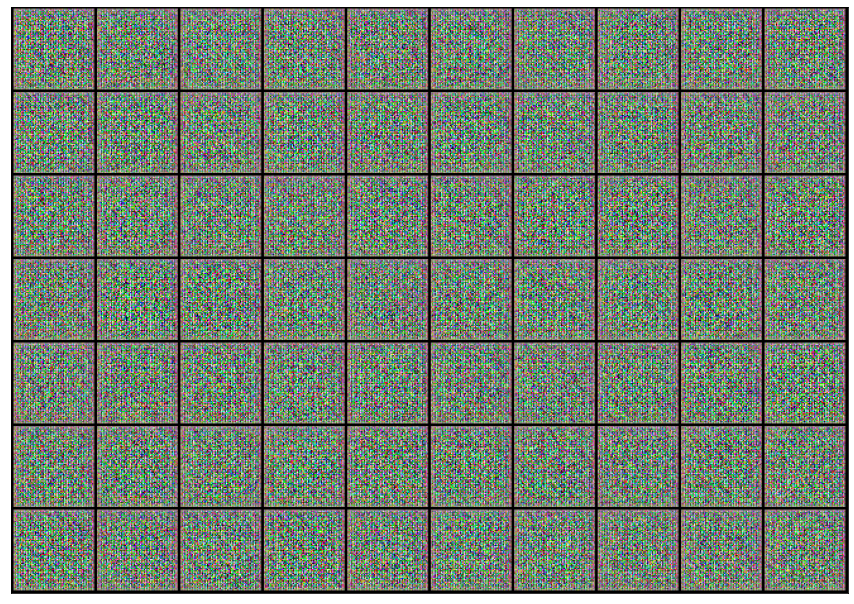

In [ ]:
# This is image formed using random numbers 
xb= torch.randn(batch_size, latent_size, 1, 1)
fake_image= generator(xb)
show_grid(fake_image)
print(fake_image.shape)

In [ ]:
# Moving the discrminator and genertor function on the device
to_device(discriminator, device)
to_device(generator, device)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 156, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(156, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [ ]:
import jovian

jovian.commit(project= project_name)

# Training Discrminator and generator 

In [ ]:
import torch.functional as F

In [ ]:
def train_discrminator(images, opt_d):
  opt_d.zero_grad()

  # Passing the real image and label for real image is 1
  real_preds= discriminator(images)
  real_target= torch.ones(images.size(0), 1, device= device)
  real_loss= F.binary_cross_entropy(real_preds, real_target)
  real_score= torch.mean(real_loss).item()

  # Generating the fake images
  latent= torch.randn(batch_size, latent_size, 1, 1, device= device)
  fake_image= generator(latent)

  # Passing the fake image and label is 0
  fake_target= torch.zeros(fake_image.size(0), 1, device= device)
  fake_preds= discriminator(fake_image)
  fake_loss= F.binary_cross_entropy(fake_preds, fake_target)
  fake_score= torch.mean(fake_loss).item()

  # Total loss of discrminator and increase the accuracy of the model
  loss= fake_loss + real_loss
  loss.backward()
  opt_d.step()

  return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()

  # Creating the vector to generate the images
  latent= torch.randn(batch_size, latent_size, 1, 1, device= device)
  fake_image= generator(latent)

  # Taking prediction and setting the label as 1 (as we want real images from the genertor)
  pred= discriminator(fake_image)
  target= torch.ones(batch_size, 1, device= device)
  loss= F.binary_cross_entropy(pred, target)

  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
# Creating the directory to store the progress of the model
sample_dir= 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
# Saving the images and plot them 
from torchvision.utils import save_image

def saving_image(index, latent_tensor, show= True):
  fake_image= generator(latent_tensor)
  fake_name= 'generated-image-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_image), os.path.join(sample_dir, fake_name), nrow= 10)
  print('Saving', fake_name)
  if show:
    fig, ax= plt.subplots(figsize= (12,12))
    ax.set_xticks([]), ax.set_yticks([])
    plt.imshow(make_grid(fake_image.cpu().detach(), nrow= 10).permute(1,2,0))

In [ ]:
# This fixed_latent is used to see the progress of the model
fixed_latent= torch.randn(batch_size, 128, 1, 1, device= device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0000.png


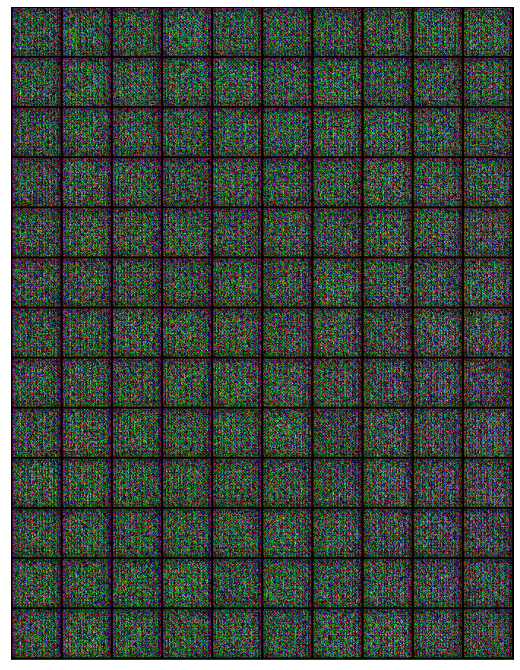

In [ ]:
# Now saving the image produce by this fixed_latent vector
saving_image(0, fixed_latent)

# Full training loop for the model
Fit method which iterate the train generator and discrimniator method to train the model

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [ ]:
def fit(epochs, lr, idx=1):

  torch.cuda.empty_cache()

  # To record the losses
  losses_g= []
  losses_d= []
  fake_score= []
  real_score= []

  opt_g= torch.optim.Adam(generator.parameters(), lr, betas=(0.5, 0.996))
  opt_d= torch.optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.996))
  
  for epoch in range(epochs):

    for real_image, _ in tqdm(train_loader):
      loss_d, real_s, fake_s= train_discrminator(real_image, opt_d)
      loss_g= train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_score.append(real_s)
    fake_score.append(fake_s)

    print('Epochs: [{}], loss_gen: {:.4f}, loss_dis: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}'.format(epoch, loss_g, loss_d, real_s, fake_s))

    saving_image(idx+epoch, fixed_latent, show= False)

  return losses_g, losses_d, real_score, fake_score

In [ ]:
jovian.commit(project= project_name, environment=None)

In [ ]:
# Defining hpyerparameteres
lr= 0.001
epochs= 30

In [ ]:
jovian.reset()
jovian.log_hyperparams(learning_rate= lr, epochs= epochs)

In [ ]:
%%time
history= fit(epochs, lr)


Epochs: [0], loss_gen: 2.9104, loss_dis: 0.8913, real_score: 0.4190, fake_score: 0.4723
Saving generated-image-0001.png



Epochs: [1], loss_gen: 2.8142, loss_dis: 1.0120, real_score: 0.9351, fake_score: 0.0769
Saving generated-image-0002.png



Epochs: [2], loss_gen: 5.0013, loss_dis: 0.6059, real_score: 0.1684, fake_score: 0.4375
Saving generated-image-0003.png



Epochs: [3], loss_gen: 7.4618, loss_dis: 0.4607, real_score: 0.1434, fake_score: 0.3172
Saving generated-image-0004.png



Epochs: [4], loss_gen: 5.4848, loss_dis: 0.4903, real_score: 0.4861, fake_score: 0.0042
Saving generated-image-0005.png



Epochs: [5], loss_gen: 2.7632, loss_dis: 0.5210, real_score: 0.4865, fake_score: 0.0345
Saving generated-image-0006.png



Epochs: [6], loss_gen: 6.0849, loss_dis: 0.2720, real_score: 0.0177, fake_score: 0.2543
Saving generated-image-0007.png



Epochs: [7], loss_gen: 5.6185, loss_dis: 0.1902, real_score: 0.0336, fake_score: 0.1566
Saving generated-image-0008.png



Epochs: [8], loss_gen: 2.7993, loss_dis: 0.4074, real_score: 0.3752, fake_score: 0.0322
Saving generated-image-0009.png



Epochs: [9], loss_gen: 7.6987, loss_dis: 0.3742, real_score: 0.0345, fake_score: 0.3397
Saving generated-image-0010.png



Epochs: [10], loss_gen: 10.9945, loss_dis: 1.1559, real_score: 0.0128, fake_score: 1.1431
Saving generated-image-0011.png



Epochs: [11], loss_gen: 6.6223, loss_dis: 0.1459, real_score: 0.0188, fake_score: 0.1271
Saving generated-image-0012.png



Epochs: [12], loss_gen: 3.8949, loss_dis: 0.5792, real_score: 0.5671, fake_score: 0.0122
Saving generated-image-0013.png



Epochs: [13], loss_gen: 4.8503, loss_dis: 0.0928, real_score: 0.0542, fake_score: 0.0386
Saving generated-image-0014.png



Epochs: [14], loss_gen: 5.1413, loss_dis: 0.1404, real_score: 0.0459, fake_score: 0.0944
Saving generated-image-0015.png



Epochs: [15], loss_gen: 4.2764, loss_dis: 0.1617, real_score: 0.1190, fake_score: 0.0427
Saving generated-image-0016.png



Epochs: [16], loss_gen: 5.1244, loss_dis: 0.1020, real_score: 0.0483, fake_score: 0.0537
Saving generated-image-0017.png



Epochs: [17], loss_gen: 12.1469, loss_dis: 3.1404, real_score: 0.0003, fake_score: 3.1400
Saving generated-image-0018.png



Epochs: [18], loss_gen: 5.8636, loss_dis: 0.1764, real_score: 0.0685, fake_score: 0.1078
Saving generated-image-0019.png



Epochs: [19], loss_gen: 6.1991, loss_dis: 0.1591, real_score: 0.0145, fake_score: 0.1446
Saving generated-image-0020.png



Epochs: [20], loss_gen: 4.6422, loss_dis: 0.1565, real_score: 0.0633, fake_score: 0.0932
Saving generated-image-0021.png



Epochs: [21], loss_gen: 4.7198, loss_dis: 0.1330, real_score: 0.0452, fake_score: 0.0879
Saving generated-image-0022.png



Epochs: [22], loss_gen: 5.6488, loss_dis: 0.1535, real_score: 0.1160, fake_score: 0.0374
Saving generated-image-0023.png



Epochs: [23], loss_gen: 6.4213, loss_dis: 0.2080, real_score: 0.0779, fake_score: 0.1302
Saving generated-image-0024.png



Epochs: [24], loss_gen: 4.9317, loss_dis: 0.1020, real_score: 0.0253, fake_score: 0.0768
Saving generated-image-0025.png



Epochs: [25], loss_gen: 4.9929, loss_dis: 0.2089, real_score: 0.2043, fake_score: 0.0046
Saving generated-image-0026.png



Epochs: [26], loss_gen: 7.3597, loss_dis: 0.5348, real_score: 0.0813, fake_score: 0.4534
Saving generated-image-0027.png



Epochs: [27], loss_gen: 3.2193, loss_dis: 0.8104, real_score: 0.8059, fake_score: 0.0044
Saving generated-image-0028.png



Epochs: [28], loss_gen: 5.2149, loss_dis: 1.5223, real_score: 0.3581, fake_score: 1.1641
Saving generated-image-0029.png



Epochs: [29], loss_gen: 4.9906, loss_dis: 0.2456, real_score: 0.1165, fake_score: 0.1290
Saving generated-image-0030.png
CPU times: user 39min 14s, sys: 26min 12s, total: 1h 5min 27s
Wall time: 1h 7min 15s


In [ ]:
losses_g, losses_d, real_score, fake_score= history

In [ ]:
history

In [ ]:
jovian.log_metrics(loss_g= losses_g[-1],
                   loss_d= losses_d[-1],
                   real_score= real_score[-1],
                   fake_score= fake_score[-1])

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Metrics logged.


In [ ]:
# Saving the weight of the model
torch.save(generator.state_dict, 'Generator.pth')
torch.save(discriminator.state_dict, 'Discrminator.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0001.png


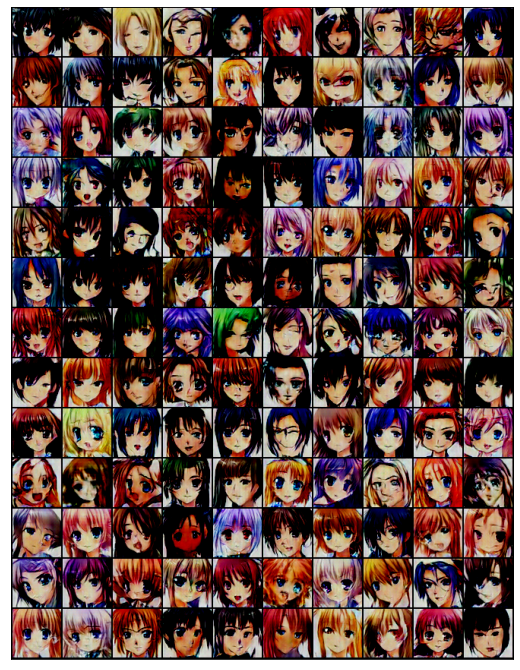

In [ ]:
saving_image(1, fixed_latent)

# Creating the video so we can see the progress of the model
For this i am using CV2 library to create the video

In [ ]:
import cv2
import os

vid_fname = 'gans_animef_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

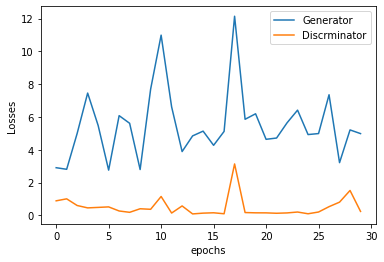

In [ ]:
# Plotting the losses of the generator and the discrminator
plt.plot(losses_g)
plt.plot(losses_d)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.legend(['Generator', 'Discrminator'])

Text(0, 0.5, 'Real_score')

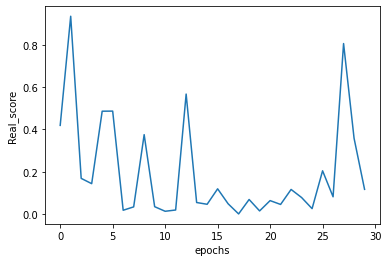

In [ ]:
# Plotting the real_score of the model
plt.plot(real_score)
plt.xlabel('epochs')
plt.ylabel('Real_score')

Text(0, 0.5, 'Real_score')

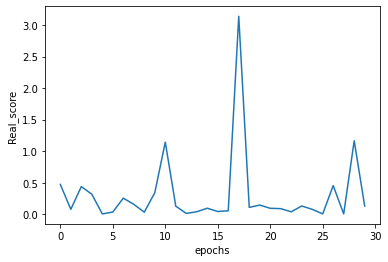

In [ ]:
# Plotting the fake_score of the model
plt.plot(fake_score)
plt.xlabel('epochs')
plt.ylabel('Real_score')

In [ ]:
# Commiting the changes 
jovian.commit(project= project_name, outputs= ['Generator.pth', 'Discrminator.pth', 'gans_animef_training.avi'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/lakshaygola/gans-anime-faces


'https://jovian.ai/lakshaygola/gans-anime-faces'